In [92]:
import matplotlib.pyplot as plt
import pretty_midi
from matplotlib.ticker import MaxNLocator
from typing import Optional
import json

In [69]:
midi_path = "nesmdb_midi/114_Faxanadu_01_02PasswordDeath.mid"
midi = pretty_midi.PrettyMIDI(midi_path)

In [ ]:
def get_channel(
    midi: pretty_midi.PrettyMIDI, channel: str
) -> Optional[pretty_midi.Instrument]:
    for instrument in midi.instruments:
        if instrument.name == channel:
            return instrument
    return None

In [ ]:
def piano_roll(channel: pretty_midi.Instrument):
    fig, ax = plt.subplots(figsize=(12, 6))
    for note in channel.notes:
        rect = plt.Rectangle(
            (note.start, note.pitch),
            width=note.end - note.start,
            height=1,
            facecolor="red",
            edgecolor="black",
        )
        ax.add_patch(rect)
    ax.set_xlim(0, channel.notes[-1].end + 1)
    ax.set_ylim(21, 127)  # MIDI range
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("MIDI pitch")
    return fig, ax

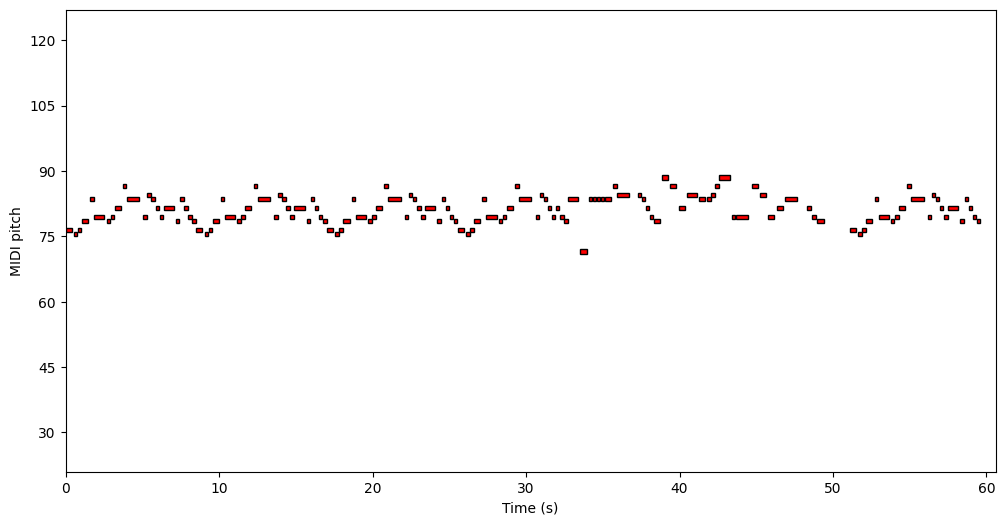

In [88]:
piano_roll(get_channel(midi, "p1"))
plt.plot()
plt.show()

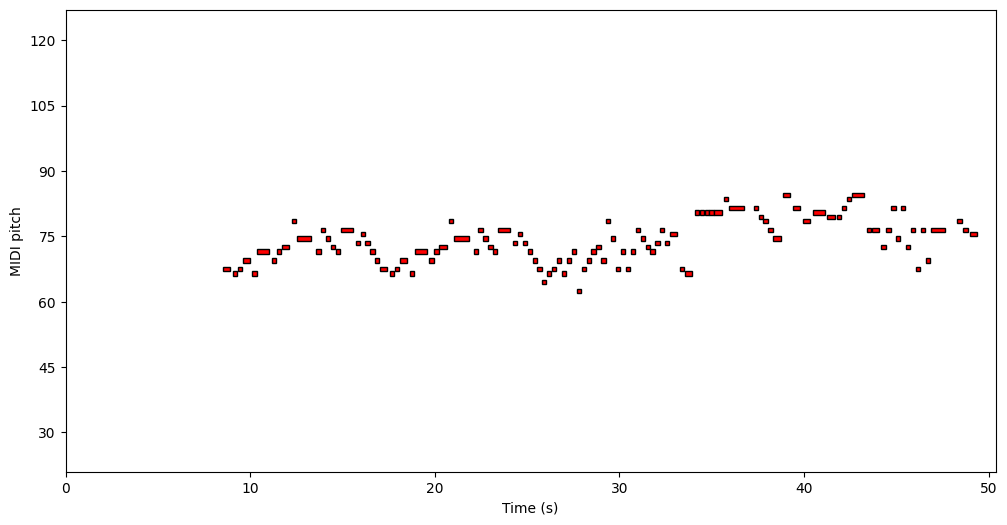

In [89]:
piano_roll(get_channel(midi, "p2"))
plt.plot()
plt.show()

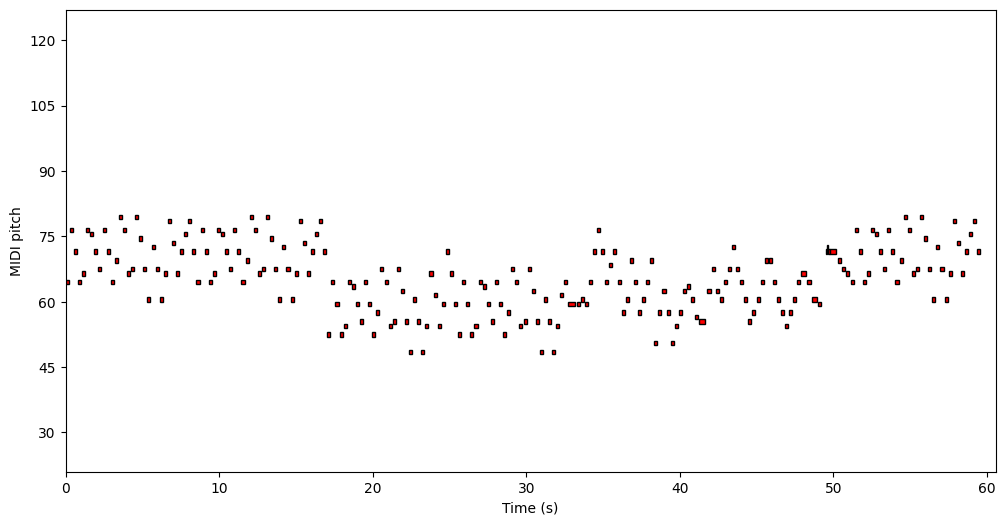

In [90]:
piano_roll(get_channel(midi, "tr"))
plt.plot()
plt.show()

In [251]:
json_path = "/Users/navidhg/Documents/smc24/amplab/ethno/nes-music-analysis/point_sets/114_Faxanadu_01_02PasswordDeath/COSIATEC/patterns_114_Faxanadu_01_02PasswordDeath_channel_p2_COSIATEC_0.json"
json_path = "/Users/navidhg/Documents/smc24/amplab/ethno/nes-music-analysis/point_sets/114_Faxanadu_01_02PasswordDeath/SIATEC-CCompress/patterns_114_Faxanadu_01_02PasswordDeath_channel_p2_SIATEC-CCOMPRESS_0.json"
with open(json_path, "r") as file:
    patterns = json.load(file)

In [252]:
n = 3

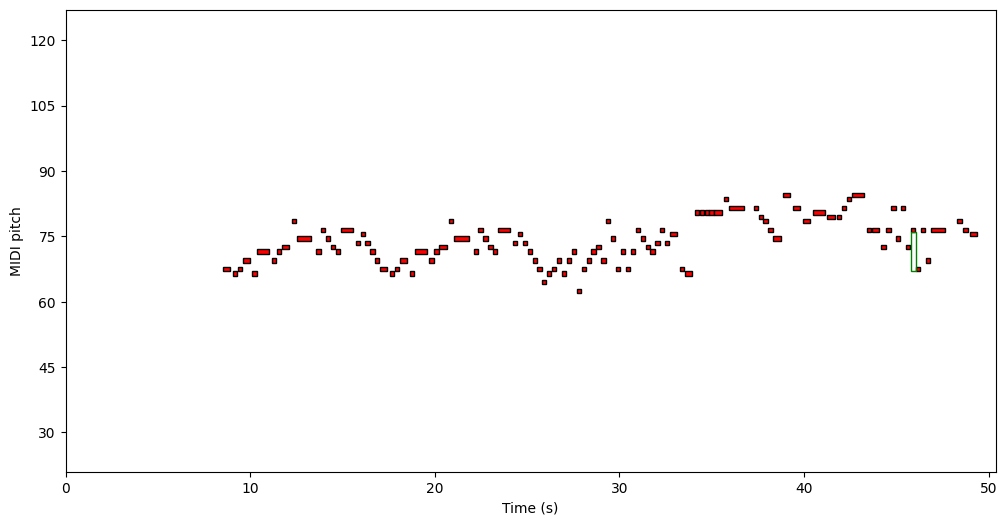

In [ ]:
fig, ax = piano_roll(get_channel(midi, "p2"))
# TODO better name
for pattern_blah in patterns[n]["occurrences"]:
    pattern = pattern_blah["data"]
    pattern_start = pattern[0][0]
    pattern_end = pattern[-1][0]
    width = pattern_end - pattern_start

    def pitch_key(elem):
        return elem[1]

    y_min = min(pattern, key=pitch_key)[1]
    y_max = max(pattern, key=pitch_key)[1]

    pattern_rect = plt.Rectangle(
        (pattern_start, y_min),
        width=width,
        height=y_max - y_min,
        fill=False,
        edgecolor="green",
    )
    ax.add_patch(pattern_rect)
plt.plot()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pretty_midi
from typing import List, Tuple, Optional

# Define a tolerance for comparing floating-point start times
DEFAULT_TIME_TOLERANCE = 1e-5


def plot_pattern_occurrence_box(
    ax: plt.Axes,
    occurrence_data: List[Tuple[float, float]],
    channel_notes: List[pretty_midi.Note],
    time_tolerance: float = DEFAULT_TIME_TOLERANCE,
    occurrence_index: Optional[int] = None,  # Optional index for warnings
):
    """
    Calculates accurate bounds for a pattern occurrence based on matched MIDI notes
    and plots a bounding box on the given matplotlib Axes.

    Args:
        ax: The matplotlib Axes object to draw on.
        occurrence_data: A list of [onset_time, pitch] pairs for the pattern occurrence.
        channel_notes: A list of all pretty_midi.Note objects for the relevant channel.
        time_tolerance: The tolerance used for matching note start times.
        occurrence_index: An optional index for identifying the occurrence in warning messages.
    """
    if not occurrence_data:
        # Optional: Print a warning if you expect occurrences to always have data
        # occurrence_msg = f" occurrence {occurrence_index}" if occurrence_index is not None else ""
        # print(f"Warning: Received empty occurrence data{occurrence_msg}. Skipping box plot.")
        return False  # Indicate nothing was plotted

    matched_notes_for_occurrence: List[pretty_midi.Note] = []

    # --- Match points in the occurrence data to actual MIDI notes ---
    for pattern_onset, pattern_pitch in occurrence_data:
        found_match = False
        # Iterate through all notes in the channel to find the match
        for note in channel_notes:
            # Compare pitch first (integer comparison is exact)
            if note.pitch == pattern_pitch:
                # Compare onset time using tolerance
                if abs(note.start - pattern_onset) < time_tolerance:
                    matched_notes_for_occurrence.append(note)
                    found_match = True
                    # Optimization: Assume one unique note matches a point.
                    # If multiple notes could start at the *exact* same time and pitch,
                    # you might need to remove this break and handle that case.
                    break
        # Optional: Warn if a specific point couldn't be matched
        # if not found_match:
        #     occurrence_msg = f" in occurrence {occurrence_index}" if occurrence_index is not None else ""
        #     print(f"Warning: No matching note found for point [{pattern_onset}, {pattern_pitch}]{occurrence_msg}")

    # --- Calculate accurate bounds from matched notes ---
    if matched_notes_for_occurrence:
        try:
            box_start = min(note.start for note in matched_notes_for_occurrence)
            # CRITICAL CHANGE: Use note.end for the temporal extent
            box_end = max(note.end for note in matched_notes_for_occurrence)
            box_min_pitch = min(note.pitch for note in matched_notes_for_occurrence)
            box_max_pitch = max(note.pitch for note in matched_notes_for_occurrence)

            # --- Plot the bounding box rectangle ---
            rect_x = box_start
            # Adjust y and height for better visual alignment with piano roll notes
            rect_y = box_min_pitch - 0.5
            rect_width = box_end - box_start  # Correct width based on note durations
            rect_height = box_max_pitch - box_min_pitch + 1

            # Ensure width and height are non-negative (can happen with single-note patterns)
            rect_width = max(0, rect_width)
            rect_height = max(
                1, rect_height
            )  # Ensure height is at least 1 for single pitch patterns

            pattern_rect = plt.Rectangle(
                (rect_x, rect_y),
                width=rect_width,
                height=rect_height,
                fill=False,
                edgecolor="lime",  # Example color
                linewidth=1.5,  # Example line width
            )
            ax.add_patch(pattern_rect)
            return True  # Indicate a box was plotted

        except ValueError:
            # This can happen if matched_notes_for_occurrence is unexpectedly empty after filtering
            occurrence_msg = (
                f" occurrence {occurrence_index}"
                if occurrence_index is not None
                else ""
            )
            print(
                f"Warning: Could not calculate bounds for{occurrence_msg} despite matching points initially."
            )
            return False

    else:
        # Optional: Warn if no notes were matched for the entire occurrence
        # occurrence_msg = f" occurrence {occurrence_index}" if occurrence_index is not None else ""
        # print(f"Warning: No notes were matched for{occurrence_msg}. Cannot draw box.")
        return False  # Indicate nothing was plotted

In [ ]:
channel_notes = get_channel(midi, "p2").notes
pattern_family = patterns[1]

for i, occurrence in enumerate(pattern_family["occurrences"]):
    occurrence_data = occurrence.get("data", [])  # Get the list of [onset, pitch]
    plot_pattern_occurrence_box(
        ax=ax,
        occurrence_data=occurrence_data,
        channel_notes=channel_notes,
        occurrence_index=i,
    )

plt.show()

Processing 1 occurrences for pattern family 3


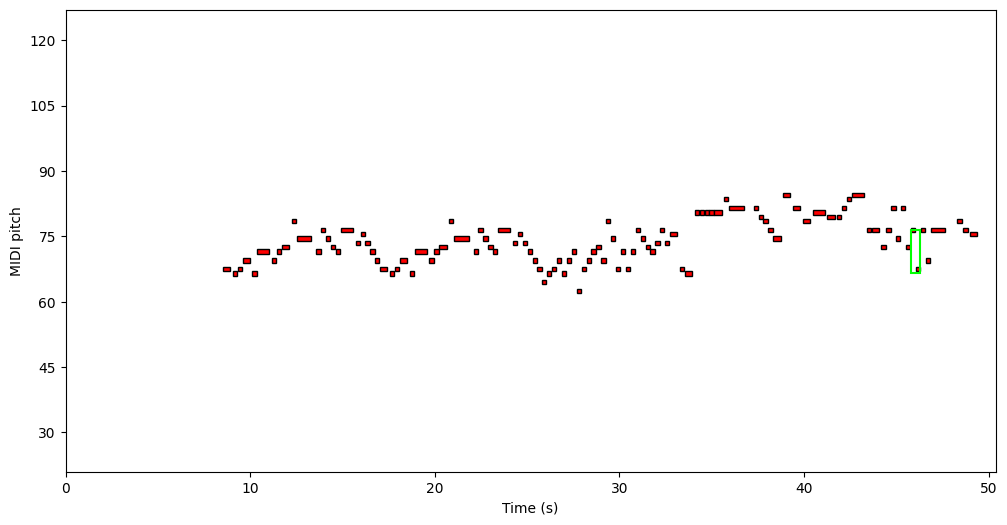

In [ ]:
import matplotlib.pyplot as plt
import pretty_midi
from typing import List, Tuple, Optional
import json
from matplotlib.ticker import MaxNLocator  # Make sure MaxNLocator is imported

# --- Assume these functions are defined as before ---
# def get_channel(...)
# def piano_roll(...)
# def plot_pattern_occurrence_box(...)
# --- And your data is loaded ---
# midi = pretty_midi.PrettyMIDI(midi_path)
# with open(json_path, "r") as file:
#     patterns = json.load(file)
target_channel_name = "p2"
pattern_family_index = 3
time_tolerance = 1e-5
# ----------------------------------------------------

# 1. Get the MIDI channel object
midi_channel = get_channel(
    midi, target_channel_name
)  # Use the correct name, e.g., "p2"

if midi_channel:
    # 2. Get the notes from this channel ONCE for efficiency
    channel_notes = midi_channel.notes

    # 3. Create the base piano roll plot FIRST
    # This creates the 'fig' and 'ax' objects
    fig, ax = piano_roll(midi_channel)

    # Check if patterns data is loaded and index is valid
    if patterns and 0 <= pattern_family_index < len(patterns):
        pattern_family = patterns[pattern_family_index]

        print(
            f"Processing {len(pattern_family.get('occurrences', []))} occurrences for pattern family {pattern_family_index}"
        )

        # 4. Loop through occurrences and add boxes to the EXISTING 'ax'
        for i, occurrence in enumerate(pattern_family.get("occurrences", [])):
            occurrence_data = occurrence.get("data", [])  # Get the list [onset, pitch]

            # Call the function to draw the box for this occurrence
            plot_pattern_occurrence_box(
                ax=ax,  # Pass the axes created by piano_roll
                occurrence_data=occurrence_data,
                channel_notes=channel_notes,  # Pass the pre-fetched notes
                time_tolerance=time_tolerance,  # Pass the tolerance
                occurrence_index=i,
            )
            # Optional: print statement to see if the loop runs
            # print(f"Attempted to plot box for occurrence {i}")

        # 5. Show the plot AFTER all drawing is done
        plt.show()

    else:
        if not patterns:
            print("Error: Patterns data not loaded.")
        else:
            print(
                f"Error: pattern_family_index {pattern_family_index} is out of range."
            )
            print(f"Number of pattern families loaded: {len(patterns)}")

else:
    print(f"Error: Could not find or process MIDI channel '{target_channel_name}'.")

Loaded 10 pattern families.
  Processing 3 occurrences for P0 (Color: lime)
  Processing 3 occurrences for P1 (Color: cyan)
  Processing 3 occurrences for P2 (Color: magenta)
  Processing 2 occurrences for P3 (Color: yellow)
  Processing 1 occurrences for P4 (Color: blue)
  Processing 1 occurrences for P5 (Color: orange)
  Processing 1 occurrences for P6 (Color: purple)
  Processing 1 occurrences for P7 (Color: gold)
  Processing 1 occurrences for P8 (Color: dodgerblue)
  Processing 30 occurrences for P9 (Color: red)


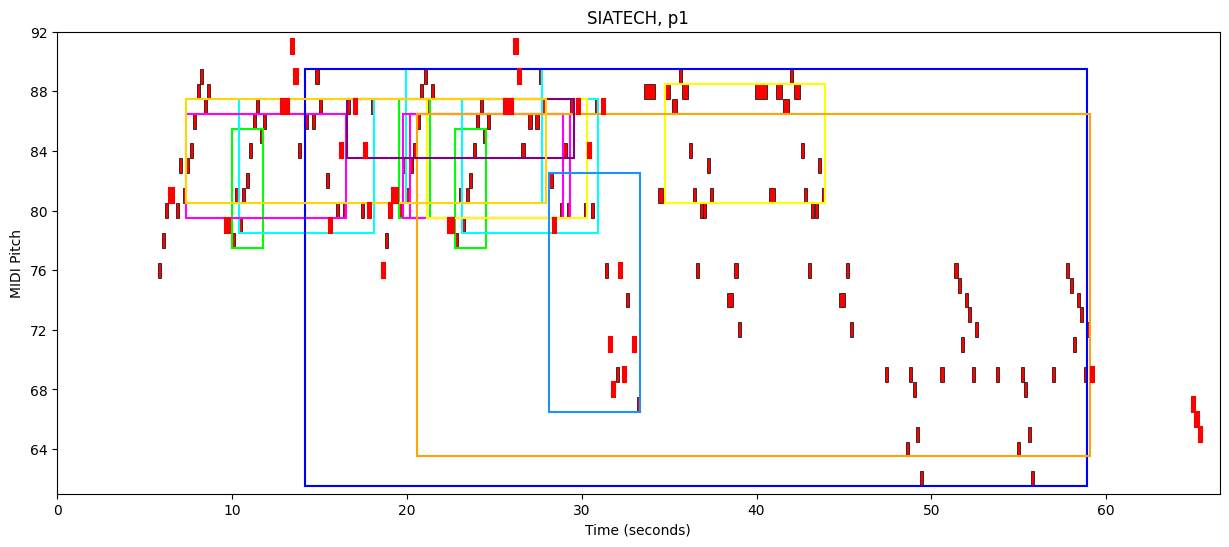

In [19]:
import matplotlib.pyplot as plt
import pretty_midi
from typing import List, Tuple, Optional
import json
from matplotlib.ticker import MaxNLocator  # Ensure MaxNLocator is imported

# --- Assume these functions are defined as before ---


def get_channel(
    midi: pretty_midi.PrettyMIDI, channel_name: str
) -> Optional[pretty_midi.Instrument]:
    """Finds an instrument (channel) by name in a PrettyMIDI object."""
    for instrument in midi.instruments:
        if instrument.name == channel_name:
            return instrument
    print(f"Warning: Channel '{channel_name}' not found in MIDI file.")
    return None


def piano_roll(channel: pretty_midi.Instrument):
    """Generates a piano roll plot for a given PrettyMIDI instrument."""
    if not channel or not channel.notes:
        print("Cannot generate piano roll: Channel is None or has no notes.")
        # Return empty figure/axes or handle appropriately
        fig, ax = plt.subplots(figsize=(15, 6))
        ax.set_title("Error: No channel data for piano roll")
        return fig, ax

    fig, ax = plt.subplots(
        figsize=(15, 6)
    )  # Increased width for potentially long patterns
    for note in channel.notes:
        rect = plt.Rectangle(
            (note.start, note.pitch - 0.5),  # Center the rectangle vertically
            width=note.end - note.start,
            height=1,
            facecolor="red",
            edgecolor="black",
            linewidth=0.5,  # Thinner lines for less clutter
        )
        ax.add_patch(rect)

    # Determine sensible limits
    min_time = 0
    max_time = max(note.end for note in channel.notes) if channel.notes else 1
    min_pitch = min(note.pitch for note in channel.notes) if channel.notes else 21
    max_pitch = max(note.pitch for note in channel.notes) if channel.notes else 108

    ax.set_xlim(min_time, max_time + 1)
    ax.set_ylim(min_pitch - 1, max_pitch + 1)  # Add some padding
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("MIDI Pitch")
    # ax.set_title(f"Piano Roll for Channel: {channel.name}")
    ax.set_title(f"SIATECH, {channel.name}")
    return fig, ax


# Define a tolerance for comparing floating-point start times
DEFAULT_TIME_TOLERANCE = 1e-5


def plot_pattern_occurrence_box(
    ax: plt.Axes,
    occurrence_data: List[Tuple[float, float]],
    channel_notes: List[pretty_midi.Note],
    box_color: str = "lime",  # Added color parameter
    time_tolerance: float = DEFAULT_TIME_TOLERANCE,
    occurrence_index: Optional[int] = None,  # Optional index for warnings
    family_label: str = "",  # Optional label for warnings
):
    """
    Calculates accurate bounds for a pattern occurrence based on matched MIDI notes
    and plots a bounding box on the given matplotlib Axes with a specific color.
    """
    if not occurrence_data:
        return False

    matched_notes_for_occurrence: List[pretty_midi.Note] = []
    points_matched_count = 0

    for pattern_onset, pattern_pitch in occurrence_data:
        found_match = False
        for note in channel_notes:
            if note.pitch == pattern_pitch:
                if abs(note.start - pattern_onset) < time_tolerance:
                    matched_notes_for_occurrence.append(note)
                    found_match = True
                    points_matched_count += 1
                    break
        if not found_match:
            occurrence_msg = (
                f" in occurrence {occurrence_index}"
                if occurrence_index is not None
                else ""
            )
            family_msg = f" of family '{family_label}'" if family_label else ""
            print(
                f"Warning: No matching note found for point [{pattern_onset:.5f}, {pattern_pitch}]{occurrence_msg}{family_msg}"
            )

    if matched_notes_for_occurrence:
        try:
            box_start = min(note.start for note in matched_notes_for_occurrence)
            box_end = max(note.end for note in matched_notes_for_occurrence)
            box_min_pitch = min(note.pitch for note in matched_notes_for_occurrence)
            box_max_pitch = max(note.pitch for note in matched_notes_for_occurrence)

            rect_x = box_start
            rect_y = box_min_pitch - 0.5
            rect_width = box_end - box_start
            rect_height = box_max_pitch - box_min_pitch + 1

            rect_width = max(0, rect_width)
            # rect_height = max(1, rect_height) # Already guaranteed by +1

            pattern_rect = plt.Rectangle(
                (rect_x, rect_y),
                width=rect_width,
                height=rect_height,
                fill=False,
                edgecolor=box_color,  # Use the passed color
                linewidth=1.5,
            )
            ax.add_patch(pattern_rect)
            return True

        except ValueError:
            occurrence_msg = (
                f" occurrence {occurrence_index}"
                if occurrence_index is not None
                else ""
            )
            family_msg = f" of family '{family_label}'" if family_label else ""
            print(
                f"Warning: Could not calculate bounds for{occurrence_msg}{family_msg} despite matching points initially."
            )
            return False
    else:
        occurrence_msg = (
            f" occurrence {occurrence_index}" if occurrence_index is not None else ""
        )
        family_msg = f" of family '{family_label}'" if family_label else ""
        print(
            f"Warning: No notes were matched at all for{occurrence_msg}{family_msg}. Cannot draw box."
        )
        return False


# ----------------------------------------------------

# --- Main Script Logic ---

# --- Configuration ---
# midi_path = "nesmdb_midi/114_Faxanadu_01_02PasswordDeath.mid"
# midi_path = "nesmdb_midi/114_Faxanadu_05_06Shop.mid"

midi_path = "nesmdb_midi/114_Faxanadu_02_03Eolis.mid"
json_path = "/Users/navidhg/Documents/smc24/amplab/ethno/nes-music-analysis/point_sets/114_Faxanadu_02_03Eolis/SIATECCompress/patterns_114_Faxanadu_02_03Eolis_channel_p1_SIATECCOMPRESS_0.json"

# json_path = "/Users/navidhg/Documents/smc24/amplab/ethno/nes-music-analysis/point_sets/114_Faxanadu_01_02PasswordDeath/COSIATEC/patterns_114_Faxanadu_01_02PasswordDeath_channel_p2_COSIATEC_0.json"
# json_path = "/Users/navidhg/Documents/smc24/amplab/ethno/nes-music-analysis/point_sets/114_Faxanadu_01_02PasswordDeath/SIATEC-CCompress/patterns_114_Faxanadu_01_02PasswordDeath_channel_p2_SIATEC-CCOMPRESS_0.json"
# json_path = "/Users/navidhg/Documents/smc24/amplab/ethno/nes-music-analysis/point_sets/114_Faxanadu_01_02PasswordDeath/COSIATEC-C/patterns_114_Faxanadu_01_02PasswordDeath_channel_p2_COSIATEC-C_0.json"
# json_path = "/Users/navidhg/Documents/smc24/amplab/ethno/nes-music-analysis/point_sets/114_Faxanadu_01_02PasswordDeath/COSIATEC-C/patterns_114_Faxanadu_01_02PasswordDeath_channel_p1_COSIATEC-C_0.json"
# json_path = "/Users/navidhg/Documents/smc24/amplab/ethno/nes-music-analysis/point_sets/114_Faxanadu_01_02PasswordDeath/SIATECCompress/patterns_114_Faxanadu_01_02PasswordDeath_channel_p1_SIATECCOMPRESS_0.json"
# json_path = "/Users/navidhg/Documents/smc24/amplab/ethno/nes-music-analysis/point_sets/114_Faxanadu_05_06Shop/COSIATEC-C/patterns_114_Faxanadu_05_06Shop_channel_p1_COSIATEC-C_0.json"
target_channel_name = "p1"  # The channel name corresponding to the JSON data
time_tolerance = 1e-5  # Tolerance for matching note start times

# Define a list of colors for different pattern families
# (Add more colors if you expect more than 10 families)
family_colors = [
    "lime",
    "cyan",
    "magenta",
    "yellow",
    "blue",
    "orange",
    "purple",
    "gold",
    "dodgerblue",
    "red",
]

# --- Load Data ---
midi = None
patterns = None
try:
    midi = pretty_midi.PrettyMIDI(midi_path)
except Exception as e:
    print(f"Error loading MIDI file '{midi_path}': {e}")

try:
    with open(json_path, "r") as file:
        patterns = json.load(file)  # This should be the list of families
except FileNotFoundError:
    print(f"Error: JSON pattern file not found at '{json_path}'")
except json.JSONDecodeError as e:
    print(f"Error decoding JSON file '{json_path}': {e}")

# --- Plotting ---
if midi and patterns:
    # Get the target MIDI channel object
    midi_channel = get_channel(midi, target_channel_name)

    if midi_channel:
        # Get all notes from this channel ONCE for efficiency
        channel_notes = midi_channel.notes

        # Create the base piano roll plot
        fig, ax = piano_roll(midi_channel)
        # ax.set_title(
        #     f"Piano Roll for Channel: {target_channel_name} with All Pattern Occurrences"
        # )
        ax.set_title(f"SIATECH, {target_channel_name}")        

        print(f"Loaded {len(patterns)} pattern families.")

        # <<< CHANGE: Loop through ALL pattern families >>>
        for family_index, pattern_family in enumerate(patterns):
            family_label = pattern_family.get("pattern", {}).get(
                "label", f"Family {family_index}"
            )
            occurrences = pattern_family.get("occurrences", [])

            # Assign color based on family index (cycling through the list)
            color_index = family_index % len(family_colors)
            current_color = family_colors[color_index]

            print(
                f"  Processing {len(occurrences)} occurrences for {family_label} (Color: {current_color})"
            )

            # Loop through occurrences within the current family
            for occurrence_index, occurrence in enumerate(occurrences):
                occurrence_data = occurrence.get("data", [])

                # Call the function to draw the box for this occurrence
                plot_pattern_occurrence_box(
                    ax=ax,
                    occurrence_data=occurrence_data,
                    channel_notes=channel_notes,
                    box_color=current_color,  # Pass the assigned color
                    time_tolerance=time_tolerance,
                    occurrence_index=occurrence_index,
                    family_label=family_label,
                )

        # Show the plot AFTER all drawing is done
        plt.show()

    else:
        print(f"Error: Could not find or process MIDI channel '{target_channel_name}'.")
elif not midi:
    print("MIDI file not loaded. Cannot proceed.")
elif not patterns:
    print("Patterns data not loaded. Cannot proceed.")

In [262]:
# Load your full PatMinr output into this variable
patminr_full_output = """
c:76 o:4 o:4.4 
c:75 o:4.5323 o:4.7583 
c:76 o:4.7984 o:5.025 
c:78 o:5.0646 o:5.4583 
c:83 o:5.5969 o:5.825 
c:79 o:5.8635 o:6.525 
c:78 o:6.662 o:6.8917 
c:79 o:6.9281 o:7.1583 
c:81 o:7.1943 o:7.5917 
c:86 o:7.7271 o:7.9583 
c:83 o:7.9932 o:8.7917 
c:79 o:9.0583 o:9.2833 
c:84 o:9.324 o:9.55 
c:83 o:9.5906 o:9.8167 
c:81 o:9.8568 o:10.0833 
c:79 o:10.1229 o:10.35 
c:81 o:10.3891 o:11.05 
c:78 o:11.188 o:11.4167 
c:83 o:11.4542 o:11.6833 
c:81 o:11.7203 o:11.95 
c:79 o:11.9865 o:12.2167 
c:78 o:12.2526 o:12.4833 
c:76 o:12.5193 o:12.9167 
c:75 o:13.0516 o:13.2833 
c:76 o:13.3177 o:13.55 
c:78 o:13.5839 o:13.9833 
c:83 o:14.1167 o:14.3417 
c:79 o:14.3828 o:15.0417 
c:78 o:15.1812 o:15.4083 
c:79 o:15.4474 o:15.675 
c:81 o:15.7141 o:16.1083 
c:86 o:16.2464 o:16.475 
c:83 o:16.5125 o:17.3083 
c:79 o:17.5776 o:17.8083 
c:84 o:17.8437 o:18.075 
c:83 o:18.1099 o:18.3417 
c:81 o:18.376 o:18.6083 
c:79 o:18.6422 o:18.875 
c:81 o:18.9089 o:19.575 
c:78 o:19.7073 o:19.9333 
c:83 o:19.9734 o:20.2 
c:81 o:20.2396 o:20.4667 
c:79 o:20.5057 o:20.7333 
c:78 o:20.7724 o:21 
c:76 o:21.0385 o:21.4333 
c:75 o:21.5708 o:21.8 
c:76 o:21.837 o:22.0667 
c:78 o:22.1036 o:22.5 
c:83 o:22.6359 o:22.8667 
c:79 o:22.9021 o:23.5667 
c:78 o:23.7005 o:23.9333 
c:79 o:23.9672 o:24.2 
c:81 o:24.2333 o:24.625 
c:86 o:24.7656 o:24.9917 
c:83 o:25.0318 o:25.825 
c:79 o:26.0969 o:26.325 
c:84 o:26.363 o:26.5917 
c:83 o:26.6292 o:26.8583 
c:81 o:26.8953 o:27.125 
c:79 o:27.162 o:27.3917 
c:81 o:27.4281 o:28.0917 
c:78 o:28.2266 o:28.4583 
c:83 o:28.4927 o:28.725 
c:81 o:28.7594 o:28.9917 
c:79 o:29.0255 o:29.2583 
c:78 o:29.2917 o:29.5167 
c:76 o:29.5578 o:29.95 
c:75 o:30.0901 o:30.3167 
c:76 o:30.3568 o:30.5833 
c:78 o:30.6229 o:31.0167 
c:83 o:31.1552 o:31.3833 
c:79 o:31.4214 o:32.0833 
c:78 o:32.2203 o:32.45 
c:79 o:32.4865 o:32.7167 
c:81 o:32.7526 o:33.15 
c:86 o:33.2849 o:33.5167 
c:83 o:33.5516 o:34.35 
c:79 o:34.6161 o:34.8417 
c:84 o:34.8823 o:35.1083 
c:83 o:35.1484 o:35.375 
c:81 o:35.4151 o:35.6417 
c:79 o:35.6813 o:35.9083 
c:81 o:35.9474 o:36.175 
c:79 o:36.2135 o:36.4417 
c:78 o:36.4797 o:36.7083 
c:83 o:36.7464 o:37.4083 
c:71 o:37.5448 o:37.9417 
c:83 o:38.0771 o:38.3083 
c:83 o:38.3432 o:38.575 
c:83 o:38.6099 o:38.8417 
c:83 o:38.876 o:39.1083 
c:83 o:39.1422 o:39.5417 
c:86 o:39.6745 o:39.9 
c:84 o:39.9411 o:40.7333 
c:84 o:41.2724 o:41.5 
c:83 o:41.538 o:41.7667 
c:81 o:41.8047 o:42.0333 
c:79 o:42.0708 o:42.3 
c:78 o:42.337 o:42.7333 
c:88 o:42.8693 o:43.2667 
c:86 o:43.4021 o:43.8 
c:81 o:43.9344 o:44.3333 
c:84 o:44.4667 o:45.1333 
c:83 o:45.2656 o:45.6583 
c:83 o:45.7979 o:46.025 
c:84 o:46.0641 o:46.2917 
c:86 o:46.3302 o:46.5583 
c:88 o:46.5969 o:47.2583 
c:79 o:47.3953 o:47.625 
c:79 o:47.6615 o:48.4583 
c:86 o:48.7266 o:49.125 
c:84 o:49.2589 o:49.6583 
c:79 o:49.7917 o:50.1833 
c:81 o:50.324 o:50.7167 
c:83 o:50.8563 o:51.65 
c:81 o:52.2875 o:52.55 
c:79 o:52.637 o:52.9 
c:78 o:52.9865 o:53.3833 
c:76 o:55.1167 o:55.5083 
c:75 o:55.6484 o:55.875 
c:76 o:55.9146 o:56.1417 
c:78 o:56.1813 o:56.575 
c:83 o:56.7135 o:56.9417 
c:79 o:56.9797 o:57.6417 
c:78 o:57.7786 o:58.0083 
c:79 o:58.0448 o:58.275 
c:81 o:58.3109 o:58.7083 
c:86 o:58.8432 o:59.075 
c:83 o:59.1099 o:59.9083 
c:79 o:60.1745 o:60.4 
c:84 o:60.4406 o:60.6667 
c:83 o:60.7068 o:60.9333 
c:81 o:60.9729 o:61.2 
c:79 o:61.2396 o:61.4667 
c:81 o:61.5057 o:62.1667 
c:78 o:62.3042 o:62.5333 
c:83 o:62.5703 o:62.8 
c:81 o:62.837 o:63.0667 
c:79 o:63.1031 o:63.3333 
c:78 o:63.3693 o:63.6 
Sequence
== 1
Pattern:  (40)
; c-1 
Pattern: ; c-1 ; c+1  (3)
; c-1 ; c+1 ; c+2 
Pattern: ; c-1 ; c+1 ; c+2 ; c+5  (3)
Pattern: c:76  (3)
c:76 ; c-1:75 
Pattern: c:76 ; c-1:75 ; c+1:76  (5)
c:76 ; c-1:75 ; c+1:76 ; c+2:78 
Pattern: c:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83  (5)
c:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 
Pattern: c:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78  (5)
c:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 
Pattern: c:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81  (5)
c:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81 ; c+5:86 
Pattern: c:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81 ; c+5:86 ; c-3:83  (5)
c:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81 ; c+5:86 ; c-3:83 ; c-4:79 
Pattern: c:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81 ; c+5:86 ; c-3:83 ; c-4:79 ; c+5:84  (5)
c:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81 ; c+5:86 ; c-3:83 ; c-4:79 ; c+5:84 ; c-1:83 
Pattern: c:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81 ; c+5:86 ; c-3:83 ; c-4:79 ; c+5:84 ; c-1:83 ; c-2:81  (5)
c:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81 ; c+5:86 ; c-3:83 ; c-4:79 ; c+5:84 ; c-1:83 ; c-2:81 ; c-2:79 
Pattern: c:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81 ; c+5:86 ; c-3:83 ; c-4:79 ; c+5:84 ; c-1:83 ; c-2:81 ; c-2:79 ; c+2:81  (5)
c:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81 ; c+5:86 ; c-3:83 ; c-4:79 ; c+5:84 ; c-1:83 ; c-2:81 ; c-2:79 ; c+2:81 ; c-3:78 
Pattern: c:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81 ; c+5:86 ; c-3:83 ; c-4:79 ; c+5:84 ; c-1:83 ; c-2:81 ; c-2:79 ; c+2:81 ; c-3:78 ; c+5:83  (4)
c:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81 ; c+5:86 ; c-3:83 ; c-4:79 ; c+5:84 ; c-1:83 ; c-2:81 ; c-2:79 ; c+2:81 ; c-3:78 ; c+5:83 ; c-2:81 
Pattern: c:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81 ; c+5:86 ; c-3:83 ; c-4:79 ; c+5:84 ; c-1:83 ; c-2:81 ; c-2:79 ; c+2:81 ; c-3:78 ; c+5:83 ; c-2:81 ; c-2:79  (4)
c:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81 ; c+5:86 ; c-3:83 ; c-4:79 ; c+5:84 ; c-1:83 ; c-2:81 ; c-2:79 ; c+2:81 ; c-3:78 ; c+5:83 ; c-2:81 ; c-2:79 ; c-1:78 
Pattern: c:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81 ; c+5:86 ; c-3:83 ; c-4:79 ; c+5:84 ; c-1:83 ; c-2:81 ; c-2:79 ; c+2:81 ; c-3:78 ; c+5:83 ; c-2:81 ; c-2:79 ; c-1:78 ; c-2:76  (3)
Pattern:  (40)
; c-1 
Pattern: ; c-1 ; c-2  (4)
c:79 
Pattern: c:79 ; c-1:78  (3)
c:84 
Pattern: c:84 ; c-1:83  (4)
c:84 ; c-1:83 ; c-2:81 
Pattern: c:84 ; c-1:83 ; c-2:81 ; c-2:79  (3)
== 2
Pattern: ; c+1  (4)
; c+1 ; c+2 
Pattern: ; c+1 ; c+2 ; c+5  (4)
== 3
Pattern:  (40)
; c+2 
Pattern: ; c+2 ; c+5  (4)
Pattern: ; c+2  (7)
Pattern:  (40)
; c+2 
Pattern: ; c+2 ; c+2  (2)
c:79 
Pattern: c:79 ; c+2:81  (5)
== 4
Pattern: c:83  (12)
c:83 ; c-2:81 
Pattern: c:83 ; c-2:81 ; c-2:79  (5)
Pattern: ; c-2  (10)
; c-2 ; c-2:79 
Pattern: ; c-2 ; c-2:79 ; c-1:78  (5)
c:83 
Pattern: c:83 ; c-2:81  (5)
c:83 ; c-2:81 ; c-2:79 
Pattern: c:83 ; c-2:81 ; c-2:79 ; c-1:78  (4)
c:83 
Pattern: c:83 ; c-2:81  (5)
c:83 ; c-2:81 ; c-2:79 
Pattern: c:83 ; c-2:81 ; c-2:79 ; c-1:78  (4)
c:83 ; c-2:81 ; c-2:79 ; c-1:78 ; c-2:76 
Pattern: c:83 ; c-2:81 ; c-2:79 ; c-1:78 ; c-2:76 ; c-1:75  (3)
c:83 ; c-2:81 ; c-2:79 ; c-1:78 ; c-2:76 ; c-1:75 ; c+1:76 
Pattern: c:83 ; c-2:81 ; c-2:79 ; c-1:78 ; c-2:76 ; c-1:75 ; c+1:76 ; c+2:78  (3)
c:83 ; c-2:81 ; c-2:79 ; c-1:78 ; c-2:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 
Pattern: c:83 ; c-2:81 ; c-2:79 ; c-1:78 ; c-2:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79  (3)
c:83 ; c-2:81 ; c-2:79 ; c-1:78 ; c-2:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 
Pattern: c:83 ; c-2:81 ; c-2:79 ; c-1:78 ; c-2:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79  (3)
c:83 ; c-2:81 ; c-2:79 ; c-1:78 ; c-2:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81 
Pattern: c:83 ; c-2:81 ; c-2:79 ; c-1:78 ; c-2:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81 ; c+5:86  (3)
c:83 ; c-2:81 ; c-2:79 ; c-1:78 ; c-2:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81 ; c+5:86 ; c-3:83 
Pattern: c:83 ; c-2:81 ; c-2:79 ; c-1:78 ; c-2:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81 ; c+5:86 ; c-3:83 ; c-4:79  (3)
c:83 ; c-2:81 ; c-2:79 ; c-1:78 ; c-2:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81 ; c+5:86 ; c-3:83 ; c-4:79 ; c+5:84 
Pattern: c:83 ; c-2:81 ; c-2:79 ; c-1:78 ; c-2:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81 ; c+5:86 ; c-3:83 ; c-4:79 ; c+5:84 ; c-1:83  (3)
c:83 ; c-2:81 ; c-2:79 ; c-1:78 ; c-2:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81 ; c+5:86 ; c-3:83 ; c-4:79 ; c+5:84 ; c-1:83 ; c-2:81 
Pattern: c:83 ; c-2:81 ; c-2:79 ; c-1:78 ; c-2:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81 ; c+5:86 ; c-3:83 ; c-4:79 ; c+5:84 ; c-1:83 ; c-2:81 ; c-2:79  (3)
c:83 ; c-2:81 ; c-2:79 ; c-1:78 ; c-2:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81 ; c+5:86 ; c-3:83 ; c-4:79 ; c+5:84 ; c-1:83 ; c-2:81 ; c-2:79 ; c+2:81 
Pattern: c:83 ; c-2:81 ; c-2:79 ; c-1:78 ; c-2:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81 ; c+5:86 ; c-3:83 ; c-4:79 ; c+5:84 ; c-1:83 ; c-2:81 ; c-2:79 ; c+2:81 ; c-3:78  (3)
c:83 ; c-2:81 ; c-2:79 ; c-1:78 ; c-2:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81 ; c+5:86 ; c-3:83 ; c-4:79 ; c+5:84 ; c-1:83 ; c-2:81 ; c-2:79 ; c+2:81 ; c-3:78 ; c+5:83 
Pattern: c:83 ; c-2:81 ; c-2:79 ; c-1:78 ; c-2:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81 ; c+5:86 ; c-3:83 ; c-4:79 ; c+5:84 ; c-1:83 ; c-2:81 ; c-2:79 ; c+2:81 ; c-3:78 ; c+5:83 ; c-2:81  (3)
c:83 ; c-2:81 ; c-2:79 ; c-1:78 ; c-2:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81 ; c+5:86 ; c-3:83 ; c-4:79 ; c+5:84 ; c-1:83 ; c-2:81 ; c-2:79 ; c+2:81 ; c-3:78 ; c+5:83 ; c-2:81 ; c-2:79 
Pattern: c:83 ; c-2:81 ; c-2:79 ; c-1:78 ; c-2:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81 ; c+5:86 ; c-3:83 ; c-4:79 ; c+5:84 ; c-1:83 ; c-2:81 ; c-2:79 ; c+2:81 ; c-3:78 ; c+5:83 ; c-2:81 ; c-2:79 ; c-1:78  (3)
Pattern:  (40)
; c-2 
Pattern: ; c-2 ; c-1:78  (3)
Pattern:  (40)
; c-2 
Pattern: ; c-2 ; c-1  (4)
Pattern:  (40)
; c-2 
Pattern: ; c-2 ; c-5  (2)
Pattern: c:81  (8)
c:81 ; c-2:79 
Pattern: c:81 ; c-2:79 ; c-1:78  (5)
c:86 
Pattern: c:86 ; c-2:84  (2)
"""


Parsed 140 notes.
Parsed 56 pattern definitions.
Searching for: ; c-1 ; c+1...
  Found 0 occurrences for Family 1 (3 expected)
Searching for: ; c-1 ; c+1 ; c+2 ; c+5...
  Found 0 occurrences for Family 2 (3 expected)
Searching for: c:76...
  Found 10 occurrences for Family 3 (3 expected)
Searching for: c:76 ; c-1:75 ; c+1:76...
  Found 5 occurrences for Family 4 (5 expected)
Searching for: c:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83...
  Found 5 occurrences for Family 5 (5 expected)
Searching for: c:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78...
  Found 5 occurrences for Family 6 (5 expected)
Searching for: c:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81...
  Found 5 occurrences for Family 7 (5 expected)
Searching for: c:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c+2:81 ; c+5:86 ; c-3:83...
  Found 5 occurrences for Family 8 (5 expected)
Searching for: c:76 ; c-1:75 ; c+1:76 ; c+2:78 ; c+5:83 ; c-4:79 ; c-1:78 ; c+1:79 ; c

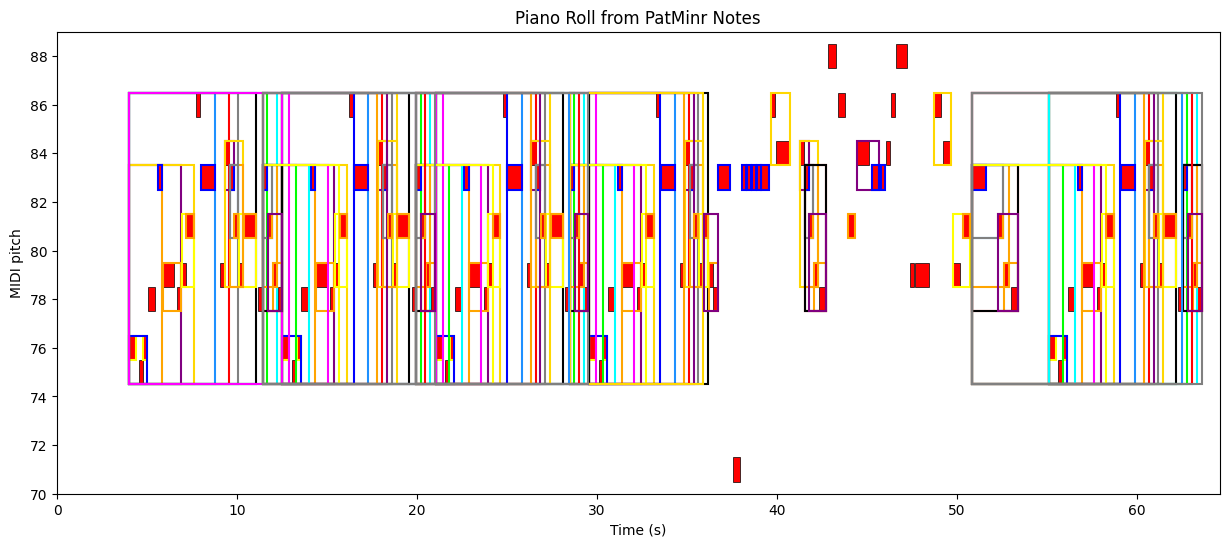

In [ ]:
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from typing import List, Dict, Any, Optional, Tuple

# --- Constants ---
DEFAULT_TIME_TOLERANCE = 1e-5  # Tolerance for float comparisons if needed

# --- Data Structures ---
# Using tuples for notes for simplicity, as pretty_midi objects aren't strictly needed here
NoteTuple = Tuple[float, float, int]  # (start_time, end_time, pitch)

# --- Parsing Functions ---


def parse_note_list(patminr_output_text: str) -> List[NoteTuple]:
    """Parses the initial note list section of the PatMinr output."""
    notes: List[NoteTuple] = []
    note_regex = re.compile(r"c:(\d+)\s+o:([\d\.]+)\s+o:([\d\.]+)")
    lines = patminr_output_text.strip().split("\n")

    for line in lines:
        line = line.strip()
        if line.startswith("Sequence"):  # Stop when sequence definition ends
            break
        if not line or line.startswith(
            "=="
        ):  # Skip empty lines or context blocks if any remain above
            continue

        match = note_regex.match(line)
        if match:
            try:
                pitch = int(match.group(1))
                onset = float(match.group(2))
                offset = float(match.group(3))
                notes.append((onset, offset, pitch))
            except ValueError:
                print(f"Warning: Could not parse note data from line: {line}")
        # else: # Optional: Warn about lines that don't match the note format
        #     print(f"Warning: Skipping non-note line before 'Sequence': {line}")

    # Sort notes by start time just in case they aren't ordered in the output
    notes.sort(key=lambda x: x[0])
    return notes


def parse_pattern_element(element_str: str) -> Optional[Dict[str, Any]]:
    """Parses a single element string from a PatMinr pattern definition."""
    element_str = element_str.strip()
    if not element_str:
        return None

    match_abs = re.match(r"^c:(\d+)$", element_str)
    if match_abs:
        return {"type": "abs", "pitch": int(match_abs.group(1))}

    match_rel_pitch = re.match(r"^c([+-]\d+):(\d+)$", element_str)
    if match_rel_pitch:
        return {
            "type": "rel_pitch",
            "interval": int(match_rel_pitch.group(1)),
            "pitch": int(
                match_rel_pitch.group(2)
            ),  # We might not need this pitch if we reconstruct
        }

    match_rel = re.match(r"^c([+-]\d+)$", element_str)
    if match_rel:
        return {"type": "rel", "interval": int(match_rel.group(1))}

    return None  # Failed to parse


def parse_pattern_definitions(patminr_output_text: str) -> List[Dict[str, Any]]:
    """
    Parses the pattern definition section (after 'Sequence') of PatMinr output.
    """
    parsed_patterns = []
    lines = patminr_output_text.strip().split("\n")
    pattern_line_regex = re.compile(r"^Pattern:\s*(.*?)\s*\((\d+)\)\s*$")
    sequence_found = False
    current_context_block = None  # Keep track of == N blocks if they exist here

    for line in lines:
        line = line.strip()
        if line.startswith("Sequence"):
            sequence_found = True
            continue
        if not sequence_found:  # Only process lines after 'Sequence'
            continue

        # Check for context blocks within the pattern section
        if line.startswith("=="):
            try:
                current_context_block = int(line.strip("= "))
            except ValueError:
                print(f"Warning: Could not parse context block ID from line: {line}")
                current_context_block = None
            continue

        match = pattern_line_regex.match(line)
        if match:
            context_to_assign = (
                current_context_block if current_context_block is not None else -1
            )
            definition_str = match.group(1).strip()
            try:
                occurrence_count = int(match.group(2))
            except ValueError:
                print(f"Warning: Could not parse occurrence count from line: {line}")
                continue

            parsed_elements = []
            if definition_str:
                elements = definition_str.split(";")
                parse_failed = False
                for element in elements:
                    element = element.strip()
                    if not element:
                        continue
                    parsed = parse_pattern_element(element)
                    if parsed:
                        parsed_elements.append(parsed)
                    else:
                        print(
                            f"Warning: Could not parse element '{element}' in pattern: {definition_str}"
                        )
                        parse_failed = True
                        break  # Stop parsing this pattern if an element fails
                if parse_failed:
                    continue  # Skip adding this pattern

            # Add pattern if it's valid (even if empty definition like 'Pattern:  (40)')
            parsed_patterns.append(
                {
                    "context_block": context_to_assign,  # Store context if available
                    "definition_str": definition_str,
                    "occurrence_count": occurrence_count,
                    "parsed_pattern": parsed_elements,  # List of parsed element dicts
                }
            )

    return parsed_patterns


# --- Plotting Functions ---


def piano_roll_from_notes(notes_list: List[NoteTuple], title: str = "Piano Roll"):
    """Generates a piano roll plot from a list of (start, end, pitch) tuples."""
    if not notes_list:
        print("Cannot generate piano roll: No notes provided.")
        fig, ax = plt.subplots(figsize=(15, 6))
        ax.set_title("Error: No note data for piano roll")
        return fig, ax

    fig, ax = plt.subplots(figsize=(15, 6))
    for start, end, pitch in notes_list:
        rect = plt.Rectangle(
            (start, pitch - 0.5),
            width=(end - start),
            height=1,
            facecolor="red",
            edgecolor="black",
            linewidth=0.5,
        )
        ax.add_patch(rect)

    min_time = 0
    max_time = max(n[1] for n in notes_list) if notes_list else 1
    min_pitch = min(n[2] for n in notes_list) if notes_list else 21
    max_pitch = max(n[2] for n in notes_list) if notes_list else 108

    ax.set_xlim(min_time, max_time + 1)
    ax.set_ylim(min_pitch - 1, max_pitch + 1)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("MIDI pitch")
    ax.set_title(title)
    return fig, ax


def plot_matched_occurrence_box(
    ax: plt.Axes, occurrence_notes: List[NoteTuple], color: str
):
    """Plots a bounding box around a list of notes representing one occurrence."""
    if not occurrence_notes:
        return

    try:
        box_start = min(n[0] for n in occurrence_notes)
        box_end = max(n[1] for n in occurrence_notes)  # Use end time
        box_min_pitch = min(n[2] for n in occurrence_notes)
        box_max_pitch = max(n[2] for n in occurrence_notes)

        rect_x = box_start
        rect_y = box_min_pitch - 0.5
        rect_width = box_end - box_start
        rect_height = box_max_pitch - box_min_pitch + 1

        rect_width = max(0, rect_width)
        # rect_height = max(1, rect_height) # Guaranteed by +1

        pattern_rect = plt.Rectangle(
            (rect_x, rect_y),
            rect_width,
            rect_height,
            fill=False,
            edgecolor=color,
            linewidth=1.5,
        )
        ax.add_patch(pattern_rect)
    except ValueError:
        print(
            "Warning: Could not calculate bounds for an occurrence (empty list passed?)."
        )


def find_and_plot_patterns(
    ax: plt.Axes,
    note_sequence: List[NoteTuple],
    pattern_definitions: List[Dict[str, Any]],
    colors: List[str],
):
    """
    Finds occurrences of defined patterns in the note sequence and plots boxes.
    NOTE: This is a complex matching task, especially with relative intervals.
    """
    num_families = len(pattern_definitions)
    total_occurrences_plotted = 0

    for family_idx, pattern_info in enumerate(pattern_definitions):
        pattern_elements = pattern_info.get("parsed_pattern", [])
        family_label = f"Family {family_idx} ({pattern_info.get('occurrence_count', '?')} expected)"
        color = colors[family_idx % len(colors)]

        if not pattern_elements:  # Skip empty patterns like "Pattern: (40)"
            continue

        print(f"Searching for: {pattern_info['definition_str']}...")
        occurrences_found_count = 0

        # Iterate through the note sequence to find starting points
        for i in range(len(note_sequence)):
            current_match_notes = []
            possible_match = True
            last_pitch = None

            # Try to match the pattern starting at note_sequence[i]
            note_idx_in_seq = i
            for element_idx, element in enumerate(pattern_elements):
                if note_idx_in_seq >= len(note_sequence):
                    possible_match = False  # Ran out of notes in sequence
                    break

                current_note = note_sequence[note_idx_in_seq]
                current_pitch = current_note[2]
                target_pitch = None

                if element["type"] == "abs":
                    target_pitch = element["pitch"]
                elif element["type"] == "rel" or element["type"] == "rel_pitch":
                    if (
                        note_idx_in_seq == i
                    ):  # First note of pattern must match absolute if available
                        if element["type"] == "rel":
                            # Cannot start matching with a purely relative interval
                            # print(f"Debug: Cannot start with relative interval at index {i}")
                            possible_match = False
                            break
                        else:  # 'rel_pitch' or 'abs' needed for first element generally
                            # This case requires more complex logic if first note is relative.
                            # Let's assume for now first element must be absolute or matchable.
                            if element["type"] == "rel_pitch":
                                target_pitch = element["pitch"]
                            # If first element is 'rel' only, this will fail.

                    elif last_pitch is not None:
                        target_pitch = last_pitch + element["interval"]
                        # Optional Check: If rel_pitch is provided, verify it matches calculation
                        # if element.get('pitch') is not None and target_pitch != element['pitch']:
                        #    print(f"Warning: Calculated pitch {target_pitch} differs from provided {element['pitch']}")
                        #    possible_match = False; break
                    else:  # Should have a last_pitch after the first note
                        possible_match = False
                        break

                # Check if the current note matches the target pitch
                if target_pitch is not None and current_pitch == target_pitch:
                    current_match_notes.append(current_note)
                    last_pitch = current_pitch
                    note_idx_in_seq += (
                        1  # Move to next note in sequence *for next element*
                    )
                else:
                    # Current note doesn't match required pitch
                    possible_match = False
                    break

            # End of inner loop (iterating through pattern elements)
            if possible_match and len(current_match_notes) == len(pattern_elements):
                # Found a full occurrence!
                occurrences_found_count += 1
                plot_matched_occurrence_box(ax, current_match_notes, color)
                # Optional: Break if you only want the first match starting at index i
                # Or implement logic to handle overlapping patterns if needed.

        print(f"  Found {occurrences_found_count} occurrences for {family_label}")
        total_occurrences_plotted += occurrences_found_count

    print(f"\nTotal occurrences plotted: {total_occurrences_plotted}")


# --- Main Execution ---


# 1. Parse the note sequence
note_data = parse_note_list(patminr_full_output)
print(f"Parsed {len(note_data)} notes.")

# 2. Parse the pattern definitions
pattern_defs = parse_pattern_definitions(patminr_full_output)
print(f"Parsed {len(pattern_defs)} pattern definitions.")

# 3. Plot the piano roll using the parsed notes
fig, ax = piano_roll_from_notes(note_data, title="Piano Roll from PatMinr Notes")

# 4. Find occurrences and plot boxes
family_colors = [  # Define colors for families
    "lime",
    "cyan",
    "magenta",
    "yellow",
    "blue",
    "orange",
    "purple",
    "gold",
    "dodgerblue",
    "red",
    "grey",
    "black",
]
find_and_plot_patterns(ax, note_data, pattern_defs, family_colors)


# 5. Show the final plot
plt.show()

In [268]:
pattern_defs[-2]

{'context_block': 4,
 'definition_str': 'c:81 ; c-2:79 ; c-1:78',
 'occurrence_count': 5,
 'parsed_pattern': [{'type': 'abs', 'pitch': 81},
  {'type': 'rel_pitch', 'interval': -2, 'pitch': 79},
  {'type': 'rel_pitch', 'interval': -1, 'pitch': 78}]}

In [45]:
import music21

In [46]:
score = music21.converter.parse(
    "nesmdb_midi/114_Faxanadu_01_02PasswordDeath.mid", quarterLengthDivisors=(16, 3)
)
part = score.parts[1]
notes = list(part.recurse().notes)

In [47]:
for note in notes:
    print(note.offset)

1.0625
2.125
2.625
3.1875
0.25
0.75
2.375
2.875
3.4375
0.0
0.5
1.0
3.125
3.6875
0.0
0.25
0.75
1.3125
1.8125
3.4375
3.9375
0.0
0.5
1.0
1.5625
2.0625
3.125
11/3
0.0
0.1875
1.25
1.8125
3.375
3.9375
0.0
0.4375
1.5625
2.0625
0.1875
0.75
1.25
1.8125
7/3
2.875
0.0
0.4375
1.0
1.5
2.0625
2.5625
3.125
11/3
0.0
0.1875
0.6875
1.25
1.75
2.3125
2.8125
3.375
3.9375
0.0
0.4375
1.0
1.5
2.0625
2.5625
3.125
3.625
0.0
0.1875
0.6875
1.25
1.75
2.3125
2.8125
3.375
3.875
0.0
0.4375
0.9375
1.5
2.5625
3.0625
0.125
0.6875
1.25
1.75
2.3125
10/3
3.875
0.0
2.5625
3.0625
3.625
0.0
0.125
2/3
1.75
2.8125
3.875
0.0
0.9375
2.5625
3.625
0.0
0.125
2/3
1.1875
2.8125
10/3
0.0
0.375
0.9375
1.4375
2.0
2.5
3.0625
3.5625
0.125
2/3
1.1875
1.6875
0.5625
1.25
2.0


In [48]:
score.show("midi")

In [49]:
score.show("musicxml")